Sentiment analysis using groq api


In [ ]:
!pip install groq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.6/109.6 kB 2.7 MB/s eta 0:00:00


In [ ]:
import groq

In [ ]:
!export GROQ_API_KEY="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"



In [ ]:
import os

os.environ["GROQ_API_KEY"] = "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"
api_key = os.getenv("GROQ_API_KEY")


In [ ]:
!pip install python-dotenv


In [ ]:
import os
from dotenv import load_dotenv
from groq import Groq


load_dotenv()
api_key = os.getenv("GROQ_API_KEY")


if not api_key:
    raise ValueError("GROQ_API_KEY environment variable is not set. Please set it before running the script.")


client = Groq(api_key=api_key)

def get_sentiment(chat_history):
    """
    Analyze the sentiment of the given chat history using the Groq API.

    Parameters:
    - chat_history (str): The chat conversation to analyze.

    Returns:
    - str: The detected sentiment (positive, negative, neutral, or frustrated).
    """
    try:

        messages = [
            {
                "role": "system",
                "content": """
                You are the customer support team assistant responsible for sentiment analysis.
                Analyze the sentiment of the given text and categorize it as one of the following:
                - Positive
                - Negative
                - Neutral
                - Frustrated
                - Positive: When the text expresses satisfaction, happiness, or appreciation.
                - Negative: When the text expresses dissatisfaction, disappointment, or anger.
                - Neutral: When the text is informative, polite, or just factual, without expressing strong emotion.
                - Frustrated: When the text includes strong language, impatience, or expresses feelings of being overwhelmed or upset.

                If the user uses strong or offensive language, the sentiment should be classified as 'Negative' or 'Frustrated'.
                Do not include any additional reasoning or text other than the sentiment label.
                """
            },
            {"role": "user", "content": chat_history}
        ]

        # API call
        completion = client.chat.completions.create(
            model="llama3-8b-8192",
            messages=messages,
            temperature=0,
            max_completion_tokens=10,
            top_p=1,
            stream=False,
            stop=None,
        )


        sentiment_raw = completion.choices[0].message.content.strip()

        # possible sentiments
        valid_sentiments = ['positive', 'negative', 'neutral', 'frustrated']


        sentiment = sentiment_raw.lower()

        if sentiment not in valid_sentiments:
            sentiment = 'neutral'

        return sentiment

    except Exception as e:
        print(f"Error during sentiment analysis: {e}")
        return "error"

# Example usage
if __name__ == "__main__":
    chat_history = "Customer: go to hell bloody people."
    sentiment = get_sentiment(chat_history)
    print(f"Detected Sentiment: {sentiment}")


Detected Sentiment: frustrated


In [ ]:
!pip install pyarrow

In [ ]:

import pandas as pd
try:
    df = pd.read_parquet('train-00000-of-00001-a5a7c6e4bb30b016.parquet')
    print("Parquet file loaded successfully.")
    # print(df.head())  # Print the head to verify
except Exception as e:
    print(f"Error loading parquet file: {e}")

Parquet file loaded successfully.


In [ ]:

print(df.head())

                  issue_area                        issue_category  \
0          Login and Account  Mobile Number and Email Verification   
1  Cancellations and returns                   Pickup and Shipping   
2  Cancellations and returns        Replacement and Return Process   
3          Login and Account       Login Issues and Error Messages   
4                      Order                 Order Delivery Issues   

                                  issue_sub_category  \
0  Verification requirement for mobile number or ...   
1           Reasons for being asked to ship the item   
2             Inability to click the 'Cancel' button   
3  Error message regarding exceeded attempts to e...   
4                       Delivery not attempted again   

                         issue_category_sub_category customer_sentiment  \
0  Mobile Number and Email Verification -> Verifi...            neutral   
1  Pickup and Shipping -> Reasons for being asked...            neutral   
2  Replacement an

In [ ]:
res = df.iloc[:30, :].apply(lambda x: get_sentiment(x["conversation"]), axis=1)



In [ ]:
res

,0
0,neutral
1,neutral
2,neutral
3,neutral
4,frustrated
5,frustrated
6,frustrated
7,neutral
8,neutral
9,negative


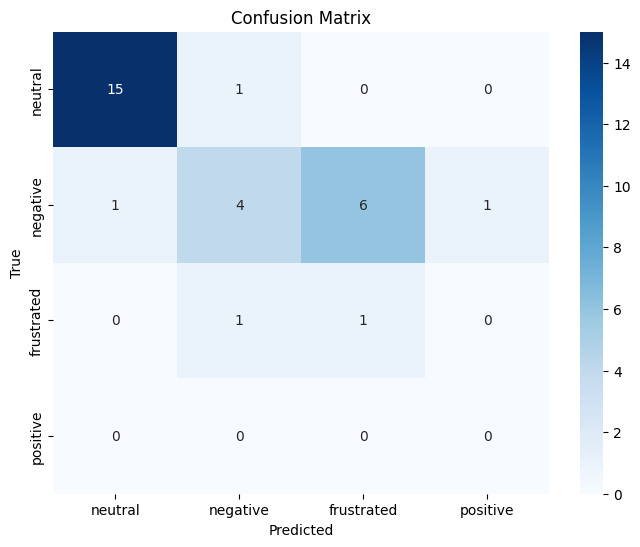

In [ ]:
# prompt:  make 4x4 confusion matrix using df["customer_sentiment"] and res, they have these possible values: 'neutral', 'negative', 'frustrated', 'positive'

import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'df["customer_sentiment"]' and 'res' are already defined as in your provided code

# Ensure both series have the same length
min_len = min(len(df["customer_sentiment"]), len(res))
df_truncated = df["customer_sentiment"][:min_len]
res_truncated = res[:min_len]

# Create the confusion matrix
cm = confusion_matrix(df_truncated, res_truncated, labels=['neutral', 'negative', 'frustrated', 'positive'])

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['neutral', 'negative', 'frustrated', 'positive'],
            yticklabels=['neutral', 'negative', 'frustrated', 'positive'])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# prompt: from above calculate f1 score for every 'customer_sentiment' category also calculate Macro-average  F1 score
# Weighted-average F1 score

from sklearn.metrics import f1_score

# Assuming df_truncated and res_truncated are defined as in the previous code
# Calculate F1 score for each category
f1_scores = f1_score(df_truncated, res_truncated, average=None, labels=['neutral', 'negative', 'frustrated', 'positive'])

# Print F1 scores for individual categories
for i, label in enumerate(['neutral', 'negative', 'frustrated', 'positive']):
    print(f"F1 Score for {label}: {f1_scores[i]}")

# Calculate Macro-average F1 score
macro_f1 = f1_score(df_truncated, res_truncated, average='macro')
print(f"\nMacro-average F1 Score: {macro_f1}")

# Calculate Weighted-average F1 score
weighted_f1 = f1_score(df_truncated, res_truncated, average='weighted')
print(f"Weighted-average F1 Score: {weighted_f1}")

F1 Score for neutral: 0.9375
F1 Score for negative: 0.4444444444444444
F1 Score for frustrated: 0.2222222222222222
F1 Score for positive: 0.0

Macro-average F1 Score: 0.40104166666666663
Weighted-average F1 Score: 0.6925925925925926


In [ ]:

'''
n=10
F1 Score for neutral: 0.9090909090909091
F1 Score for negative: 0.0
F1 Score for frustrated: 0.4
F1 Score for positive: 0.0

Macro-average F1 Score: 0.43636363636363634
Weighted-average F1 Score: 0.4945454545454545
n=30
F1 Score for neutral: 0.9142857142857143
F1 Score for negative: 0.0
F1 Score for frustrated: 0.3076923076923077
F1 Score for positive: 0.0

Macro-average F1 Score: 0.4073260073260074
Weighted-average F1 Score: 0.5081318681318681

F1 Score for neutral: 0.8823529411764706
F1 Score for negative: 0.4444444444444444
F1 Score for frustrated: 0.25
F1 Score for positive: 0.0

Macro-average F1 Score: 0.525599128540305
Weighted-average F1 Score: 0.6650326797385621

F1 Score for neutral: 0.9375
F1 Score for negative: 0.4444444444444444
F1 Score for frustrated: 0.2222222222222222
F1 Score for positive: 0.0

Macro-average F1 Score: 0.40104166666666663
Weighted-average F1 Score: 0.6925925925925926



'''